# Self-Driving Car Engineer Nanodegree

## Project: **Finding Lane Lines on the Road** 

## Import Packages

In [1]:
#importing packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
import math
%matplotlib inline

## Lane Detection Pipeline

Below are the functions to detect lanes.

## Apply the Grayscale transform

grayscale() returns the input image with only one color channel by calling cvtColor().

COLOR_RGB2GRAY: converts from RGB space to gray.

In [2]:
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

## Apply Gaussian smoothing

gaussian_blur() applies Gaussian smoothing to the input image by calling GaussianBlur(). This reduces noise and  spurious gradients in the image.

kernel_size: should be an odd number which indicates the level of the filter applied. The larger the kernel size is, implies a blurrier image but also more time process. Different kernel sizes should be used in order to get the best filter value (i.e. 3,5,7,9,11,13,15,...)

In [3]:
def gaussian_blur(img, kernel_size=5):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

## Apply Canny transform

canny() applies the Canny transform to the image. The canny tranform helps to find edges in the image, for example the lane lines which is our final obective. It detects gradients in the image, where pixels intensity changes rapidly.  

The algorithm will first detect strong edge (strong gradient) pixels above the high_threshold, and reject pixels below the low_threshold. Next, pixels with values between the low_threshold and high_threshold will be included as long as they are connected to strong edges.

A reasonable range for threshold parameters would be in the tens to hundreds. Converting to grayscale has left us with an 8-bit image, so each pixel can take 2^8 = 256 possible values. Hence, the pixel values range from 0 to 255.
This range implies that derivatives (essentially, the value differences from pixel to pixel) will be on the scale of tens or hundreds.

In [4]:
def canny(img, low_threshold=50, high_threshold=150):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

## Apply a region of interest

region_of_interest() applies a polygon mask to the image. The region inside the polygon is preserved.

In [5]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


## Draw lines

grayscale() returns the input image with only one color channel by calling cvtColor().

COLOR_RGB2GRAY: converts from RGB space to gray.

In [6]:
def draw_lines(image, lines, color=[255, 0, 0], thickness=15):

    slope = 0

    xy_sum_left = 0
    x_sum_left = 0
    y_sum_left = 0
    x_square_sum_left = 0
    number_points_left = 0
    left_computation = [xy_sum_left, x_sum_left, y_sum_left, x_square_sum_left]

    xy_sum_right=0
    x_sum_right=0
    y_sum_right=0
    x_square_sum_right=0
    number_points_right=0
    right_computation = [xy_sum_right, x_sum_right, y_sum_right, x_square_sum_right]

    # Compute line slopes from the input 
    for line in lines:
        for x1,y1,x2,y2 in line:
            # Avoid null operations in vertical lines
            if x2==x1:
                continue
            slope = (y2-y1)/(x2-x1)
            if slope < 0:
                # Discard bad negative slopes
                if slope > -.5 or slope < -.8:
                    continue
                left_computation[0] += x1*y1 + x2*y2
                left_computation[1] += x1 + x2
                left_computation[2] += y1 + y2
                left_computation[3] += x1*x1 + x2*x2
                number_points_left+=2
            elif slope > 0:
                # Discard bad positive slopes
                if slope < .5 or slope > .8:
                    continue
                right_computation[0] += x1*y1 + x2*y2
                right_computation[1] += x1 + x2
                right_computation[2] += y1 + y2
                right_computation[3] += x1*x1 + x2*x2
                number_points_right+=2

    # Get slope, intersect parameters for the extrapolated left line
    try:
        slope=0
        intersect = 0
        slope = (left_computation[0] - (left_computation[1]*left_computation[2]/number_points_left))/(left_computation[3]-(left_computation[1]*left_computation[1]/number_points_left))
        intersect = (left_computation[2] - slope*left_computation[1])/number_points_left
        x1= (image.shape[0]-intersect)/slope
        x2= (int(image.shape[0]*0.6)-intersect)/slope
        cv2.line(image, (int(x1), int(image.shape[0])), (int(x2), int(image.shape[0]*0.6)), color, thickness)
    except:
        print("Error on left lane")
        pass

    # Get slope, intersect parameters for the extrapolated right line
    try:
        slope=0
        intersect = 0
        slope = (right_computation[0] - (right_computation[1]*right_computation[2]/number_points_right))/(right_computation[3]-(right_computation[1]*right_computation[1]/number_points_right))
        intersect = (right_computation[2] - slope*right_computation[1])/number_points_right
        x1= (image.shape[0]-intersect)/slope
        x2= (int(image.shape[0]*0.6)-intersect)/slope
        cv2.line(image, (int(x1), int(image.shape[0])), (int(x2), int(image.shape[0]*0.6)), color, thickness)
    except:
        print("Error on right lane")
        pass

## Apply Hough transform

hough_lines() applies Hough transform to detect lines on the image got after applying Canny transform. HoughLinesP() returns an array containing the endpoints (x1, y1, x2, y2) of all line segments detected by the transform operation.

weighted_img() draws the lane lines on top of the original image.

In [7]:

def hough_lines(img):
    # Define Hough parameters
    rho = 2              # distance resolution in pixels of the Hough grid
    theta = np.pi/180    # angular resolution in radians of the Hough grid
    threshold = 42       # minimum number of votes (intersections in Hough grid cell)
    min_line_len = 38    # minimum number of pixels making up a line
    max_line_gap = 100   # maximum gap in pixels between connectable line segments
    
    """
    `img` should be the output of a Canny transform.
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]),
                            minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Build a Lane Finding Pipeline

Solution to get and show lanes on the original image:

- select just white and yellow color from the image which represent the lanes we want
- apply the gray scale transform
- reduce image noise before detect edges
- find edges using Canny tranform to detect gradients
- mask the region of interest
- Apply Hough transform to find lines
- draw red lines on top of the image

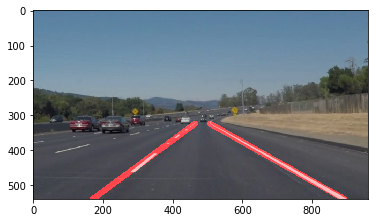

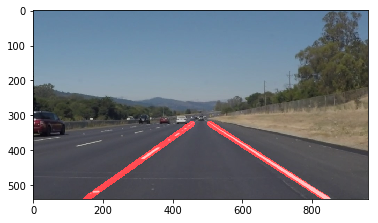

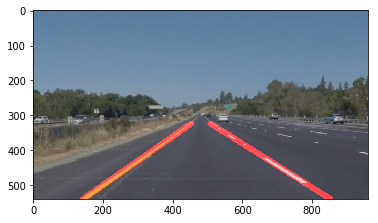

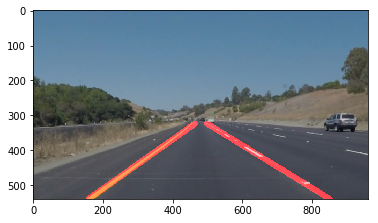

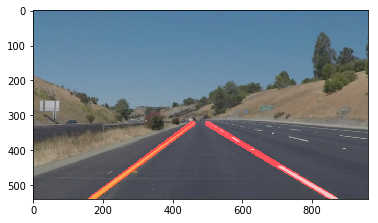

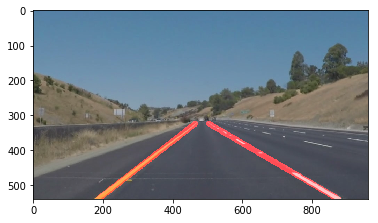

In [9]:
# Get all images from test directory
images_list = os.listdir("test_images/")

def process_image(image):
    # Make a copy to the image so we preserve the original one
    copy_image = np.copy(image)

    # Apply the Grayscale transform
    gray_image = grayscale(copy_image)

    # Apply Gaussian smoothing with kernel_size=5
    blur_gray = gaussian_blur(gray_image)

    # Apply canny transform to detect edges with (50, 150) as threshold
    edges = canny(blur_gray)

    # Define region of interest. In this case a four side polygon
    imshape = image.shape # Get image x,y sizes
    vertices = np.array([[(60,imshape[0]),((imshape[1]/2) - 25, imshape[0] * 0.6),
                          ((imshape[1]/2) + 25, imshape[0] * 0.6),
                          (imshape[1] - 60, imshape[0])]], dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)

    # Apply hough transform
    line_image = hough_lines(masked_edges)

    # Draw lanes on top of the original image
    weighted_image = weighted_img(line_image, image, α=0.8, β=1., λ=0.)
    
    # Return the processed image
    return weighted_image

def iterate_images():
    # Process each image in the tuple
    for image_name in images_list:
        # Read image from disk
        image = mpimg.imread('test_images/' + image_name)
        # Process image through the pipeline
        output_image = process_image(image)
        # Show the image
        plt.figure()
        plt.imshow(output_image)
        # Save the image
        mpimg.imsave('test_images_output/' + image_name, output_image, format="jpg")
        
iterate_images()

## Test on Videos

In [10]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [11]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:03<00:00, 67.80it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 7.26 s, sys: 232 ms, total: 7.5 s
Wall time: 3.65 s


In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [13]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:11<00:00, 60.05it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 23.7 s, sys: 624 ms, total: 24.3 s
Wall time: 11.9 s


In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

In [15]:
challenge_output = 'test_videos_output/challenge.mp4'
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


 42%|████▏     | 106/251 [00:02<00:03, 36.59it/s]

Error on right lane


 44%|████▍     | 110/251 [00:02<00:03, 35.48it/s]

Error on left lane
Error on left lane
Error on left lane
Error on right lane


 51%|█████     | 127/251 [00:03<00:03, 33.11it/s]

Error on left lane
Error on left lane
Error on left lane
Error on left lane


 52%|█████▏    | 131/251 [00:03<00:03, 32.28it/s]

Error on left lane
Error on left lane


100%|██████████| 251/251 [00:07<00:00, 37.00it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 11 s, sys: 356 ms, total: 11.4 s
Wall time: 7.8 s


In [16]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))